# 本文总结自 https://lilianweng.github.io/lil-log/2017/10/29/object-recognition-for-dummies-part-1.html

## image gradient vector 基本概念

假设图片某点 $(x,y)$ 处像素值为 $f(x,y)$。该像素点的 gradient vector 定义如下：

$$
\triangledown f(x,y) = 
\left[
\begin{matrix}
g_x  \\
g_y
\end{matrix}
\right] =
\left[
\begin{matrix}
\frac{\partial f}{\partial x}  \\
\frac{\partial f}{\partial y}
\end{matrix}
\right] = 
\left[
\begin{matrix}
f(x+1,y) - f(x-1,y)  \\
f(x, y+1) - f(x, y-1)
\end{matrix}
\right]
$$

与 image gradient vector 有关的两个量：
- Magnitude,即该向量的 L2 范数 $g=\sqrt{g^2_x+g^2_y}$
- Direction,相当与斜率对应的角度 $\theta = \arctan (g_y/g_x)$

下面看一个计算实例：

In [2]:
import numpy as np
import scipy.signal as sig

In [3]:
data = np.array([[0, 105, 0], [40, 255, 90], [0, 55, 0]])

<img src="./pic/image_gradient.png" alt="drawing" width="600"/>

计算中间那个像素点的 gradient vector 以及两个变量

$$
\triangledown f = 
\left[
\begin{matrix}
f(x+1,y) - f(x-1,y)  \\
f(x, y+1) - f(x, y-1)
\end{matrix}
\right] = 
\left[
\begin{matrix}
55 - 105  \\
90 - 40
\end{matrix}
\right] = 
\left[
\begin{matrix}
-50  \\
50
\end{matrix}
\right]
$$

- magnitude is $\sqrt{(-50)^2 + 50^2} = 70.71$
- direction is $\arctan(50/(-50)) = 135^\circ$

我们可以将上述计算 gradient 的过程够造成卷积形式，用**卷积核** $[-1, 0, 1]$ 依次与图中像素块做运算。

In [5]:
G_x = sig.convolve2d(data, np.array([[-1, 0, 1]]), mode='valid')
G_y = sig.convolve2d(data, np.array([[-1], [0], [1]]), mode='valid')

In [6]:
G_x

array([[  0],
       [-50],
       [  0]])

In [7]:
G_y

array([[ 0, 50,  0]])

### 常用的卷积 kernel

- **Prewitt operator**: 不仅仅用左右上下的像素点，而是用周围的 8 个

$$
G_x = 
\left[
\begin{matrix}
-1 & 0 & +1 \\
-1 & 0 & +1 \\
-1 & 0 & +1
\end{matrix}
\right] * A , ~~~~~
G_y = 
\left[
\begin{matrix}
+1 & +1 & +1\\
0 & 0 & 0 \\
-1 & -1 & -1
\end{matrix}
\right] * A
$$

- **Sobel operator**: 也是用 8 个，但是周围的 4 个是重点

$$
G_x = 
\left[
\begin{matrix}
-1 & 0 & +1 \\
-2 & 0 & +2 \\
-1 & 0 & +1
\end{matrix}
\right] * A , ~~~~~
G_y = 
\left[
\begin{matrix}
+1 & +2 & +1\\
0 & 0 & 0 \\
-1 & -2 & -1
\end{matrix}
\right] * A
$$

### 图片实例

![Ginobili](./pic/Ginobili.jpg)

#### 首先转化成灰度图

In [3]:
import numpy as np
import scipy.signal as sig
import cv2
import matplotlib.pyplot as plt

In [4]:
img = cv2.imread("./pic/Ginobili.jpg", 0) # 0 表示以灰度图读入

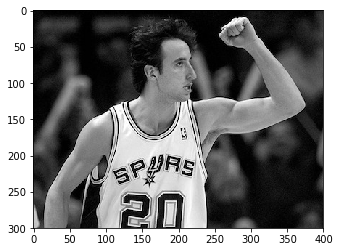

In [5]:
plt.imshow(img, cmap='gray')

#### 用 Sobel operator kernel

In [6]:
kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

In [7]:
G_x = sig.convolve2d(img, kernel_x, mode='same')
G_y = sig.convolve2d(img, kernel_y, mode='same')

Text(0.5,0,'Gy')

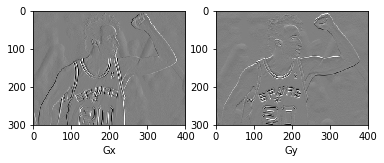

In [8]:
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow((G_x + 255)/2, cmap='gray')
ax1.set_xlabel("Gx")

ax2 = fig.add_subplot(122)
ax2.imshow((G_y + 255)/2, cmap='gray')
ax2.set_xlabel("Gy")

上述图片就是进行 Sobel operator 卷积之后的效果。

原本卷积之后元素值在 [-255, 255] 之间，为了显示，需要转化为 [0, 255]。通过 (G_x + 255)/2 方式转化之后，原本很多的 0 都变成了 125，对应了灰色。

### Histogram of Oriented Gradients (HOG)

实际上就是对前述 gradient vector 的统计，也算是从图片中提取 feature 

#### 步骤

1. 预处理图片，例如 resizing, color 2 gray 等
2. 计算每个 pixel 的 gradient vector 及其 magnitude, direction
3. 将整个图片划分成很多 8×8 像素点的 cell, 将 cell 中这 64 个 pixel 的 magnitude 成比例的分配到 9 个 bin 中，bin 对应了 0-180 direction。这样就的到了一个 cell 对应的 histogram of gradients.

![HOG](./pic/HOG.png)

4. 以 2×2 cells 作为一个 block,其中 4 个 cell 对应的 HOG 拼接成一个 36 个元素的一维向量，并进行归一化（L2 范数为 1）。最后整幅图片的 HOG 是所有 block 对应的 HOG 的拼接。这个最终的向量就可以作为 feature 送入机器学习算法进行分类。

#### 程序实现

(基于前边的 G_x, G_y)

In [18]:
cell_x = G_x[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
cell_y = G_y[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]

In [21]:
a = [[1,2],[3,4]]
a

[[1, 2], [3, 4]]

In [32]:
b = np.sqrt(a)
b

array([[1.        , 1.41421356],
       [1.73205081, 2.        ]])

In [33]:
b.flatten()

array([1.        , 1.41421356, 1.73205081, 2.        ])

In [16]:
N_BUCKETS = 9
CELL_SIZE = 8  # Each cell is 8x8 pixels
BLOCK_SIZE = 2  # Each block is 2x2 cells

def assign_bucket_vals(m, d, bucket_vals):
    left_bin = int(d / 20.)
    # Handle the case when the direction is between [160, 180)
    right_bin = (int(d / 20.) + 1) % N_BUCKETS
    assert 0 <= left_bin < right_bin < N_BUCKETS

    left_val= m * (right_bin * 20 - d) / 20
    right_val = m * (d - left_bin * 20) / 20
    bucket_vals[left_bin] += left_val
    bucket_vals[right_bin] += right_val

def get_magnitude_hist_cell(loc_x, loc_y):
    # (loc_x, loc_y) defines the top left corner of the target cell.
    cell_x = G_x[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    cell_y = G_y[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    magnitudes = np.sqrt(cell_x * cell_x + cell_y * cell_y)
    directions = np.abs(np.arctan(cell_y / cell_x) * 180 / np.pi)

    buckets = np.linspace(0, 180, N_BUCKETS + 1)
    bucket_vals = np.zeros(N_BUCKETS)
    map(
        lambda (m, d): assign_bucket_vals(m, d, bucket_vals), 
        zip(magnitudes.flatten(), directions.flatten())
    )
    return bucket_vals

def get_magnitude_hist_block(loc_x, loc_y):
    # (loc_x, loc_y) defines the top left corner of the target block.
    return reduce(
        lambda arr1, arr2: np.concatenate((arr1, arr2)),
        [get_magnitude_hist_cell(x, y) for x, y in zip(
            [loc_x, loc_x + CELL_SIZE, loc_x, loc_x + CELL_SIZE],
            [loc_y, loc_y, loc_y + CELL_SIZE, loc_y + CELL_SIZE],
        )]
    )

/home/automan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in divide


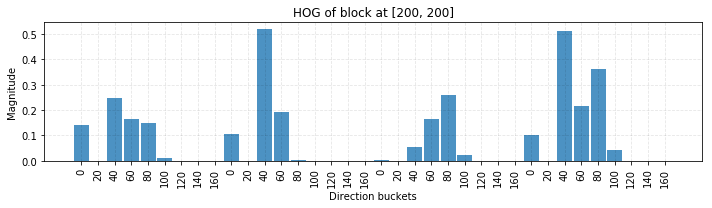

In [17]:
# Random location [200, 200] as an example.
loc_x = loc_y = 200

ydata = get_magnitude_hist_block(loc_x, loc_y)
ydata = ydata / np.linalg.norm(ydata)   # 这里的 normalization 对应了 L2 范数为 1.

xdata = range(len(ydata))
bucket_names = np.tile(np.arange(N_BUCKETS), BLOCK_SIZE * BLOCK_SIZE)

assert len(ydata) == N_BUCKETS * (BLOCK_SIZE * BLOCK_SIZE)
assert len(bucket_names) == len(ydata)

plt.figure(figsize=(10, 3))
plt.bar(xdata, ydata, align='center', alpha=0.8, width=0.9)
plt.xticks(xdata, bucket_names * 20, rotation=90)
plt.xlabel('Direction buckets')
plt.ylabel('Magnitude')
plt.grid(ls='--', color='k', alpha=0.1)
plt.title("HOG of block at [%d, %d]" % (loc_x, loc_y))
plt.tight_layout()

## 图片分割 image segmentation

找出某个包含 Object 的区域，然后更高效的进行 object detection.

### 2004 年 Felzenszwalb’s Algorithm

基本思想是基于 pixels 的相似性归为一个 component。

基于图连边的方式，如果两个节点之间连边权重比较大，则属于同一个 component.


skimage 中自带了该算法。


**实例**：

![Ginobili2](./pic/Ginobili2.jpg)

In [4]:
import skimage.segmentation
import cv2

In [2]:
from matplotlib import pyplot as plt

In [14]:
img2 = cv2.imread("./pic/Ginobili2.jpg", 0)
segment_mask1 = skimage.segmentation.felzenszwalb(img2, scale=100)
segment_mask2 = skimage.segmentation.felzenszwalb(img2, scale=1000)

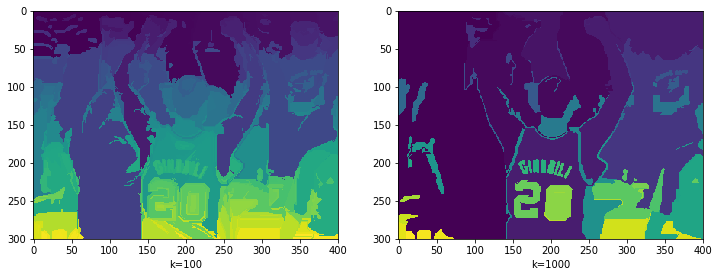

In [15]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121)
ax1.imshow(segment_mask1)
ax1.set_xlabel("k=100")

ax2 = fig.add_subplot(122)
ax2.imshow(segment_mask2)
ax2.set_xlabel("k=1000")

plt.show()

### Selective Search

Selective search 算法主要用来提供 region proposal 存在潜在的 object 的去区域。

它是在 Felzenszwalb 算法得到 image segmentation 的基础上，自下而上的对 region 进行组合，不断创建新的 region.

算法如下：

<img src="./pic/selective_search.png" width=600>

本质上就是考虑 segmentation 得到的 region，也考虑由这些 region 组合之后的新的 region.

### Selective Search 实例 （opencv 实现）

In [14]:
import sys
import cv2
 
# read image
im = cv2.imread("./pic/cats-dogs.jpg")

# resize image
newHeight = 400
newWidth = int(im.shape[1]*400/im.shape[0])
im = cv2.resize(im, (newWidth, newHeight))    

# create Selective Search Segmentation Object using default parameters
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# set input image on which we will run segmentation
ss.setBaseImage(im)

# Fast but low recall Selective Search method
#ss.switchToSelectiveSearchFast()

# High recall but slow Selective Search method
ss.switchToSelectiveSearchQuality()


# run selective search segmentation on input image
rects = ss.process()
print('Total Number of Region Proposals: {}'.format(len(rects)))

# number of region proposals to show
numShowRects = 100

# increment to increase/decrease total number
# of reason proposals to be shown
increment = 50

while True:
    # create a copy of original image
    imOut = im.copy()

    # itereate over all the region proposals
    for i, rect in enumerate(rects):
        # draw rectangle for region proposal till numShowRects
        if (i < numShowRects):
            x, y, w, h = rect
            cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1)
            #cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        else:
            break

    # show output
    cv2.imshow("Output", imOut)

    # record key pressq
    k = cv2.waitKey(0) & 0xFF

    # m is pressed
    if k == 109:
        # increase total number of rectangles to show by increment
        numShowRects += increment
    # l is pressed
    elif k == 108 and numShowRects > increment:
        # decrease total number of rectangles to show by increment
        numShowRects -= increment
    # q is pressed
    elif k == 113:
        break
# close image show window
cv2.destroyAllWindows()

Total Number of Region Proposals: 3999


In [ ]:
q

## 评价指标

**mAP**: mean average precision

- 对于每个 class 画一个 precision-recall 曲线，AP 就是曲线下的面积
- 对所有的 class 取平均，就的到了 mAP

**IoU**: intersection over union

A detection is a true positive if it has IoU with a ground-truth box greater than some threshold (usually 0.5, 一般写作 mAP\@0.5)

## R-CNN family

- R-CNN : Region-based CNN
- Fast R-CNN
- Faster R-CNN
- Mask R-CNN

### R-CNN

![RCNN](./pic/RCNN.png)

基本思路：
1. 选择一个预训练的网络模型，例如 VGG、ResNet 等
2. 通过 selective search 选择若干区域 region of interest == RoI，每幅图约 2K 个，不同的 size
3. 每个 RoI 都被 resize 到固定的 size，作为 CNN 的 input
4. fine-tuning CNN 
5. 对于每个 region，经过 CNN 之后得到 feature vector, 然后送入 binary SVM，这个 SVM 对每个 class 都是单独训练的
6. 由于最开始提出来的 RoI 不一定正好是 bounding box，为了降低定位误差，还要训练一个 regression model，输出最后的 bounding box 

训练 R-CNN 非常慢，主要原因如下：

- 每张图片要产生 2000 个 RoI
- 每个 RoI 都要产生一个 CNN feature
- 整个过程中包含三个 model：用于 image classification 和 feature extraction 的 CNN，用于确定 object 的 SVM，和用于修正 bounding box 的 regression model

### Fast R-CNN

为了让 R-CNN 训练快一些，R-CNN 的原作者 Girshick 提出了 Fast R-CNN.

<img src="./pic/fast-RCNN.png" width=500>

主要思想是将 R-CNN 中的三个 model 进行某种程度的合并，共享一些计算结果。


**步骤**:
1. 首先依然是要有个 pre-trained CNN
2. 然后还是要通过 selective search 得到 2K 个 RoI
3. 对 pre-trained CNN 做如下修改：
   - 将最后的 max pooling layer 替换为 RoI pooling layer，输出固定长度的 feature vectors. 
   - 替换最后的 FC 和 softmax layer 为新的 FC 和 softmax layer，输出为 K+1 类，包括了背景
4. 最后输出分出来连个分支：一个是计算每个 RoI 的概率分布，另一个是 bounding box 的 regression model，用来预测 offsets relative to the original RoI for each class.

Fast R-CNN 依然不够快，因为提出 RoI selective search 过程没有融合进来。

### Faster R-CNN

依然是 R-CNN 原作者组里，提出了 Faster R-CNN，用统一的 model 包含了 region proposal network RPN 和之前的 fast R-CNN 

![faster-RCNN](./pic/faster-RCNN.png)

**步骤**
1. 还是 pre-trained CNN
2. Fine-tuning RPN，初始就是上边的 pre-tained model 的 feature map。令窗口滑过 image，基于每个窗口的中心，选择不同 scale，不同 ratio 的窗口。在训练时， positive sample IoU > 0.7, negative sample IoU < 0.3
3. 基于现在 RPN 产生的 region 来训练 Fast R-CNN
4. 然后用选良好的 Fast R-CNN 进行 RPN 的训练，保持 conv layer 不变，只 fine-tune RPN 层。RPN 和 detection network 共享 conv layer
5. 最后再 fine-tune Fast R-CNN 
6. 上边的 4,5 步可以多次重复。

### Mask R-CNN

还是原作者组里， Kaiming He 等人扩展了 Faster R-CNN 到了 pixel-level image segmentation. 原来的 Faster R-CNN 只是 classification + bounding box，现在加入了 segmentation.

<img src="./pic/mask-rcnn.png" width=600>

实际上只是在 Faster 基础上多了一个 branch 用来做 segmentation.

另外还改进了 Faster 中的 RoI pooling layer，变成了 RoIAlign layer，使 RoI 可以更精确的对应到原图的 regions 中。

因为在原 RoI pooling layer 中采用了量化的形式，会有一些 misalignment，Mask 中去掉了量化误差，例如用 x/16 代替 [x/16].

<img src="./pic/roi-align.png" width=600>

这样 A region of interest is mapped accurately from the original image onto the feature map without rounding up to integers.

最终效果如下：

<img src="./pic/mask-rcnn-examples.png" width=500>

### R-CNN family 总结

![rcnn-family-summary](./pic/rcnn-family-summary.png)

## Fast Detection Models

- SSD
- RetinaNet
- YOLO family